In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from lumicks import pylake
from lumicks.pylake.kymotracker.kymotrack import KymoTrack, KymoTrackGroup

In [2]:
def create_output_folder(data_folder, folder_name):
    """
    Create an output folder if it doesn't exist.

    :param data_folder: Path to the data folder.
    :param folder_name: Name of the output folder.
    :return: Path to the output folder.
    """
    output_folder = os.path.join(data_folder, folder_name)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    return output_folder

def process_tracks(data, kymo, channel):
    """
    Process tracks from JSON data and create KymoTrack objects.

    :param data: JSON data containing track information.
    :param kymo: Kymograph object.
    :param channel: Channel to use for the tracks.
    :return: KymoTrackGroup object containing all tracks.
    """
    tracks = []
    for track in data['objects']:
        track_data = track['points']['exterior']
        column1 = [sublist[0] for sublist in track_data]
        column2 = [sublist[1] for sublist in track_data]

        column1 = [1 if num == 0 else num for num in column1]
        column1 = [kymo.shape[1] - 1 if num == kymo.shape[1] else num for num in column1]

        track = KymoTrack(time_idx=column1, localization=column2, kymo=kymo, channel=channel, minimum_observable_duration=None)
        tracks.append(track)
    return KymoTrackGroup(tracks)

def plot_tracks(data_folder, kymo, tracks, json_file, refined=False):
    """
    Plot tracks on the kymograph.

    :param kymo: Kymograph object.
    :param tracks: KymoTrackGroup object containing tracks.
    :param json_file: JSON file name for title purposes.
    :param refined: Boolean indicating if the tracks are refined.
    """
    plt.figure(figsize=(20, 5))
    kymo.plot(channel='red', aspect='auto', adjustment=pylake.ColorAdjustment(0, 98, mode="percentile"), cmap='afmhot')

    for i, track in enumerate(tracks):
        t, pos = track.seconds, track.position
        g = plt.plot(t, pos, linewidth=1.5, path_effects=[pe.withStroke(linewidth=4, foreground="black")])
        plt.annotate(i, (t[0] + 0.5, pos[0] - 0.5), fontsize=16, color=g[0].get_color(), path_effects=[pe.withStroke(linewidth=4, foreground="black")])
    
    title_suffix = '_refined' if refined else ''
    plt.title(json_file.removesuffix('.tiff.json') + title_suffix)

    save_folder = create_output_folder(data_folder, 'refined_tracks/images/')
    title_suffix = '_refined' if refined else ''
    plt.savefig(os.path.join(save_folder, json_file.removesuffix('.tiff.json') + title_suffix + '.png'), dpi=1000, bbox_inches='tight')
    plt.show()
    
def save_track_info(track, json_file, data_folder, track_id, refinedtracks, kymo_pixelsize_um):
    """
    Save detailed track information to CSV files.

    :param track: KymoTrack object.
    :param json_file: JSON file name for title purposes.
    :param data_folder: Path to the data folder.
    :param track_id: Track index.
    :param refinedtracks: Refined tracks for comparison.
    """
    track_pos = track.position
    track_pos_pix = track_pos/kymo_pixelsize_um
    track_time_pix = track.time_idx
    track_time_s = track.seconds
    track_photon_counts = track.photon_counts
    track_photon_counts_summed = track.sample_from_image(num_pixels=4, correct_origin=True)
    test_track_photon_counts = refinedtracks[track_id].sample_from_image(num_pixels=1, correct_origin=True)
    
    track_long_info = pd.DataFrame({
        'track_time_pix': track_time_pix,
        'track_time_s': track_time_s,
        'track_pos_pix': track_pos_pix,
        'track_pos_um': track_pos,
        'track_photon_counts': track_photon_counts
    })
    
    save_folder = create_output_folder(data_folder, 'refined_tracks/long_csv/')
    track_long_info.to_csv(os.path.join(save_folder, json_file.removesuffix('.tiff.json') + 'track_' + str(track_id) + '.csv'), index=False)


def save_short_track_info(json_file, data_folder, track_id, dwell_time):
    """
    Save short track information to CSV files.

    :param json_file: JSON file name for title purposes.
    :param data_folder: Path to the data folder.
    :param track_id: Track index.
    :param dwell_time: Dwell time of the track.
    """
    track_short_info_names = ["ID", "dwell time (s)"]
    track_short_info = pd.DataFrame(np.array([track_id, dwell_time])).T
    track_short_info.columns = track_short_info_names
    
    save_folder = create_output_folder(data_folder, 'refined_tracks/short_csv/')
    track_short_info.to_csv(os.path.join(save_folder, json_file.removesuffix('.tiff.json') + 'track_' + str(track_id) + '.csv'),index=False)

def process_json_files(data_folder, json_path, channel='red'):
    """
    Process all JSON files to extract and refine tracks, and save the results.

    :param data_folder: Path to the data folder.
    :param json_path: Path to the JSON files.
    :param channel: Channel to use for the tracks, default is 'red'.
    """
    json_files = [f for f in os.listdir(json_path) if f.endswith('.json')]
    for json_file in sorted(json_files):
        marker_name = json_file.split('_')[0]
        kymo_id = json_file.split('_')[2].split('.')[0]

        with open(os.path.join(json_path, json_file), 'r') as f:
            data = json.load(f)
        if len(data['objects']) == 0: continue
        
        marker = pylake.File(os.path.join(data_folder, marker_name + '.h5'))
        kymo = marker.kymos[kymo_id]
        kymo_pixelsize_um = kymo.pixelsize_um

        tracks = process_tracks(data, kymo, channel)

        refinedtracks = pylake.refine_tracks_gaussian(tracks, window=3, refine_missing_frames=True, overlap_strategy='simultaneous')

        plot_tracks(data_folder, kymo, refinedtracks, json_file, refined=True)

        for track_id, track in enumerate(refinedtracks):
            save_track_info(track, json_file, data_folder, track_id, refinedtracks,kymo_pixelsize_um)
        
            dwell_time = track.duration
            save_short_track_info(json_file, data_folder, track_id, dwell_time)




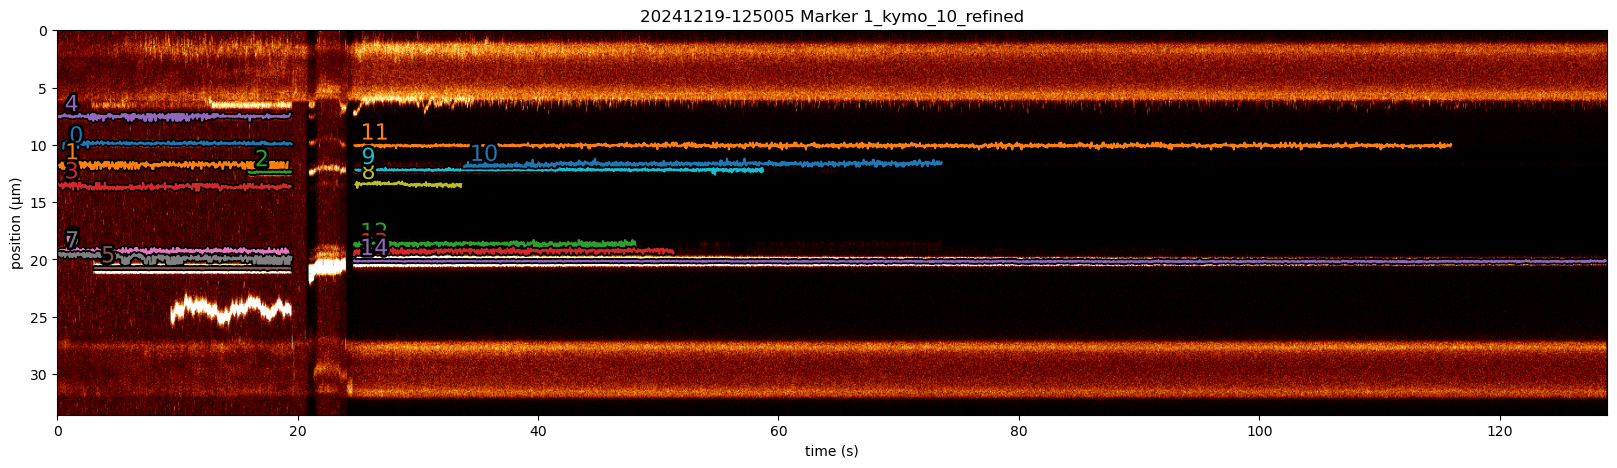

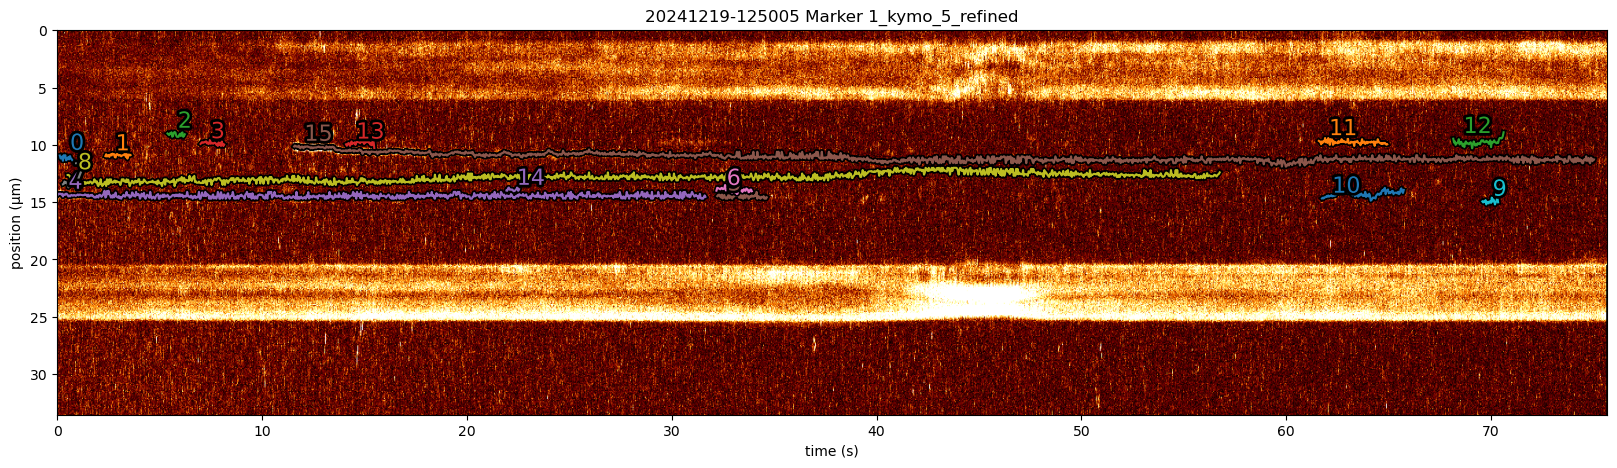

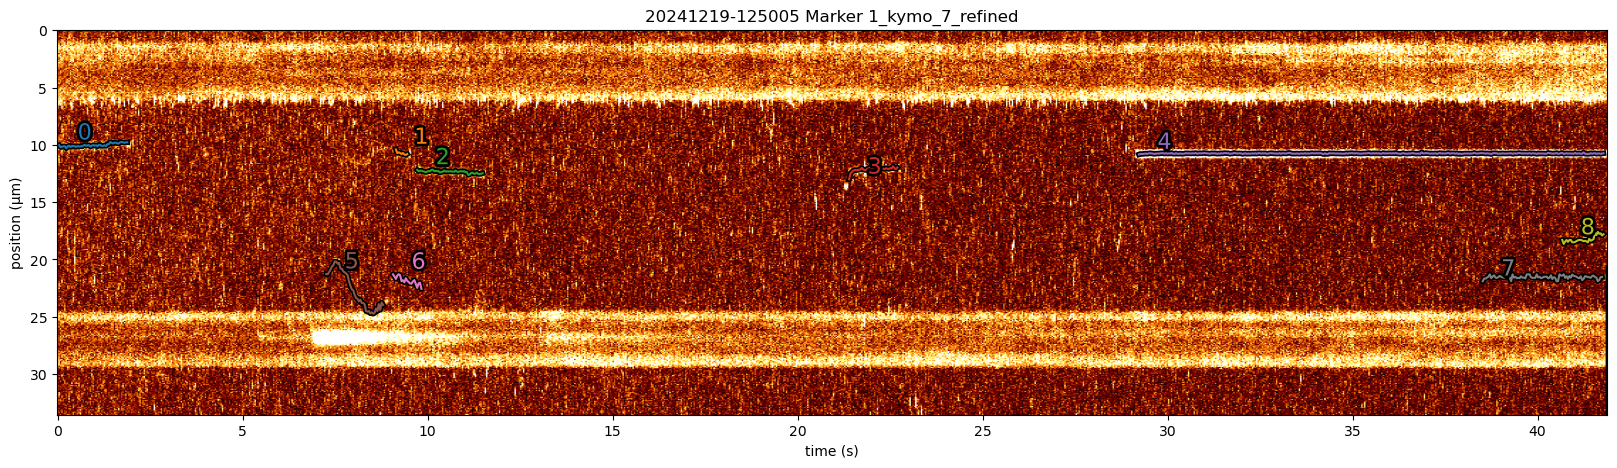

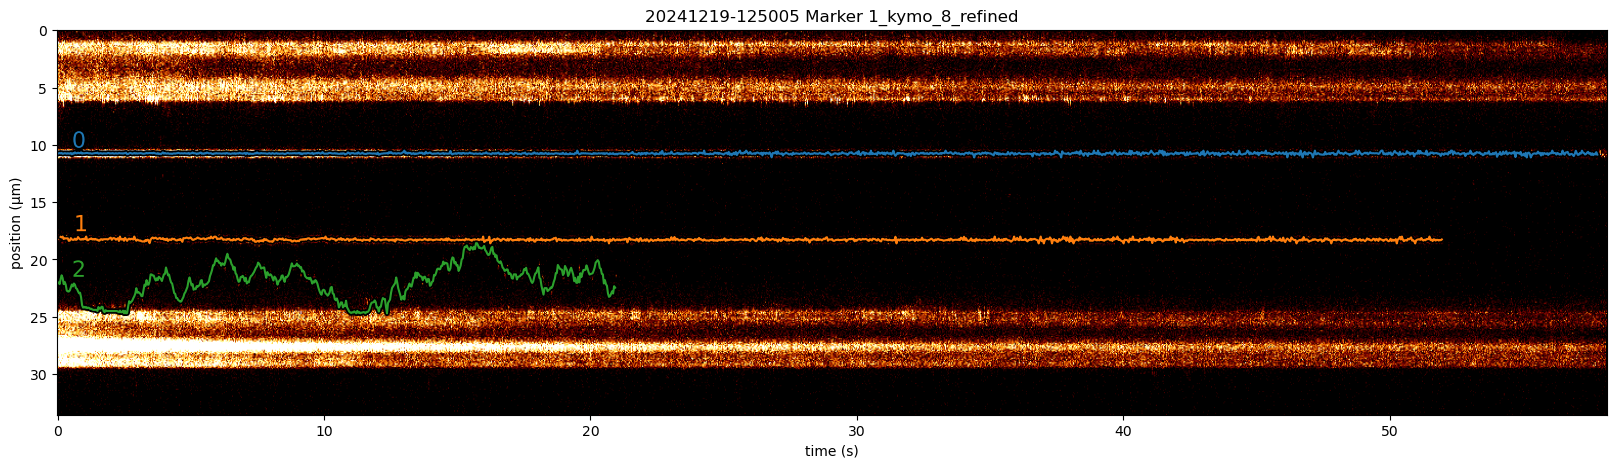

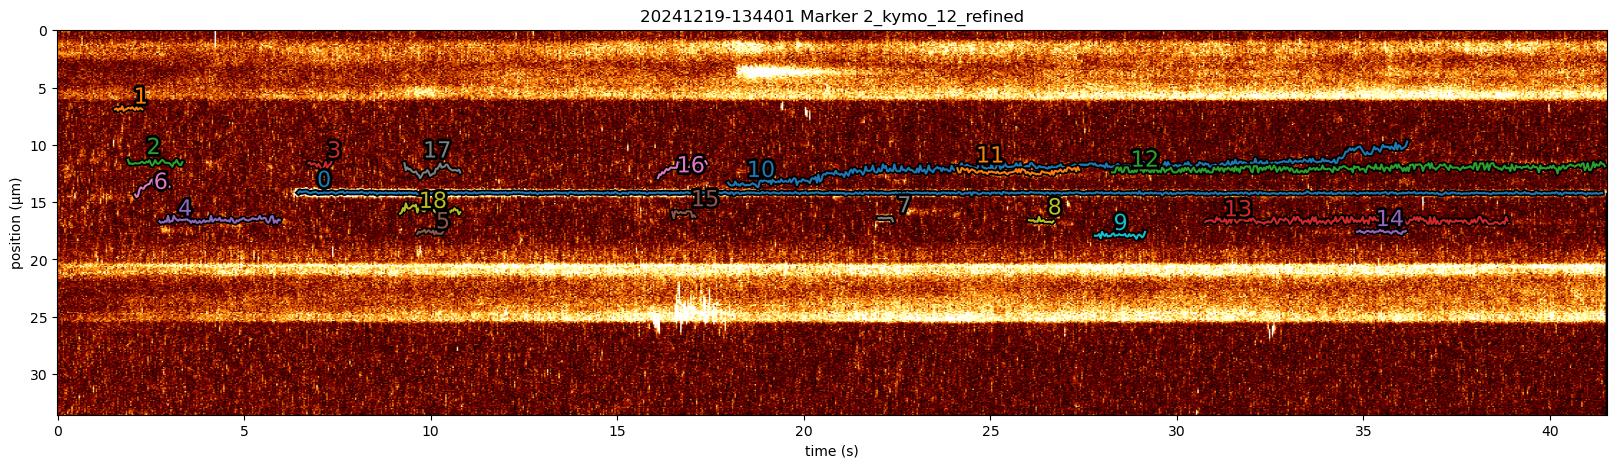

In [3]:
data_folder = '../test_folder/'


# Define the data folder path and JSON path
json_path = os.path.join(data_folder, 'manual_tracks_json/')

# Process all JSON files
process_json_files(data_folder, json_path)